# Task A: NLP Cousework

In [1]:
# built-in
import re
import codecs
import random

# common libs
import pandas as pd
import numpy as np 
from tqdm import tqdm

# plotting libs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='dark')

# nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


# torch
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#sklearn
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


#bayes_opt
from bayes_opt import BayesianOptimization


# PART I

## Loading the data

In [2]:
data = pd.read_csv("training-v1/offenseval-training-v1.tsv", delimiter='\t', engine='c')
data_test = pd.read_csv("Test_A_Release/testset-taska.tsv", delimiter='\t', engine='c')
data.head(5)

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [3]:
tweets = np.array(data.tweet)
tweets_test = np.array(data_test.tweet)

## Exploration

In [4]:
tweets[:5]

array(['@USER She should ask a few native Americans what their take on this is.',
       '@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL',
       'Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT',
       '@USER Someone should\'veTaken" this piece of shit to a volcano. 😂"',
       '@USER @USER Obama wanted liberals &amp; illegals to move into red states'],
      dtype=object)

## Cleaning

In [5]:
regexp1 = r'@[A-Za-z0-9]+'
regexp2 = r'https?://[A-Za-z0-9./]+'

combined_regexp = r'|'.join((regexp1, regexp2)) #getting rid of @USER and potentiel URLs

def low_stemmed_token_sentence(string, regexp = combined_regexp, SW = False):
# this tokenizer just accepts alphabetic word (remove numeric)
        
    cleaned = re.sub(regexp, '', string)
    tokenizer = RegexpTokenizer('[a-z]+') #splits the string into substrings we strip the # 
    stemmer = PorterStemmer() #basically it is suffix stripping
    
    low = cleaned.lower().replace('url', '')
    tokens = tokenizer.tokenize(low)
    if SW == True:
        stopWords = set(stopwords.words('english')) #creates a set of words that will be ignored
        filtered_tokens = []
        for tok in tokens:
            if tok not in stopWords:
                filtered_tokens.append(tok)
        tokens = filtered_tokens
        
    stemmed_tokens = [stemmer.stem(i) for i in tokens]
    return ((stemmed_tokens))

low_stemmed_token_sentence(tweets[1])

['go', 'home', 'you', 're', 'drunk', 'maga', 'trump']

In [6]:
cleaned_tweets = [low_stemmed_token_sentence(x, SW=True) for x in tweets]
cleaned_tweets_test_2 = [low_stemmed_token_sentence(x, SW=True) for x in tweets_test]

## Tests

In [7]:
cleaned_tweets[:2]

[['ask', 'nativ', 'american', 'take'],
 ['go', 'home', 'drunk', 'maga', 'trump']]

In [8]:
tweets[:5]

array(['@USER She should ask a few native Americans what their take on this is.',
       '@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL',
       'Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT',
       '@USER Someone should\'veTaken" this piece of shit to a volcano. 😂"',
       '@USER @USER Obama wanted liberals &amp; illegals to move into red states'],
      dtype=object)

## Preprocessing for PyTorch to have tensors

In [12]:
nb_train = len(cleaned_tweets)
print(f"Number of labeled tweets in the trainining set :{nb_train}")
nb_test=len(cleaned_tweets_test_2)
print(f"Number of unlabeled tweets in the test set {nb_test}")


all_cleaned_tweets = np.concatenate([cleaned_tweets, cleaned_tweets_test_2])
print(f"which makes a total of {all_cleaned_tweets.shape[0]} tweets")

Number of labeled tweets in the trainining set :13240
Number of unlabeled tweets in the test set 860
which makes a total of 14100 tweets


In [15]:
def get_word2idx(tokenized_corpus):
    vocabulary = []
    for sentence in tokenized_corpus:
        for token in sentence:
            if token not in vocabulary:
                vocabulary.append(token)
    word2idx = {w: idx+1 for (idx, w) in enumerate(vocabulary)}
    word2idx['<pad>'] = 0     # we reserve the 0 index for the placeholder token
    return word2idx

def get_model_inputs(tokenized_corpus, word2idx, labels, max_len):
    # we index our sentences
    vectorized_sents = [[word2idx[tok] for tok in sent if tok in word2idx] for sent in tokenized_corpus]
  
    # we create a tensor of a fixed size filled with zeroes for padding

    sent_tensor = Variable(torch.zeros((len(vectorized_sents), max_len))).long()
    sent_lengths = [len(sent) for sent in vectorized_sents]
  
    # we fill it with our vectorized sentences 
  
    for idx, (sent, sentlen) in enumerate(zip(vectorized_sents, sent_lengths)):

        sent_tensor[idx, :sentlen] = torch.LongTensor(sent)
        label_tensor = torch.FloatTensor(labels)
  
    return sent_tensor, label_tensor

cleaned_tweets_train, cleaned_tweets_val, cleaned_tweets_test, cleaned_tweets_test_2 \
= all_cleaned_tweets[:nb_train-3000], all_cleaned_tweets[nb_train-3000:nb_train-1500], \
    all_cleaned_tweets[nb_train-1500:nb_train] , all_cleaned_tweets[nb_train:]

word2idx = get_word2idx(all_cleaned_tweets)

sent_lengths = [len(sent) for sent in all_cleaned_tweets]
max_len = np.max(np.array(sent_lengths))

In [18]:
# label words to integers
labels = np.array(data.subtask_a)
labels[labels == 'OFF'] = 1
labels[labels == 'NOT'] = 0
labels = list(labels)
labels_train, labels_val, labels_test = labels[:-3000], labels[-3000:-1500], labels[-1500:]

In [20]:
train_sent_tensor, train_label_tensor = get_model_inputs(cleaned_tweets_train, word2idx, labels_train, max_len)
valid_sent_tensor, valid_label_tensor = get_model_inputs(cleaned_tweets_val, word2idx, labels_val, max_len)
test_sent_tensor, test_label_tensor = get_model_inputs(cleaned_tweets_test, word2idx, labels_test, max_len)
test_sent_tensor_2, _ = get_model_inputs(cleaned_tweets_test_2, word2idx, labels_test[:840], max_len)

# PART II

## Traditional Machine Learning

We are using BoW and Random Forest here.

In [22]:
train_valid_test = list(cleaned_tweets_train) + list(cleaned_tweets_val)+ list(cleaned_tweets_test) + \
        list(cleaned_tweets_test_2)
    
train_valid_test = [' '.join(s) for s in train_valid_test]
train_list = [' '.join(s) for s in list(cleaned_tweets_train)]
valid_list =[' '.join(s) for s in list(cleaned_tweets_val)]
test_list =[' '.join(s) for s in list(cleaned_tweets_test)]
aside_list = [' '.join(s) for s in list(cleaned_tweets_test_2)]


vectorizer = CountVectorizer()
#11687 words in the voc
X = vectorizer.fit(train_valid_test)

BOW_train = vectorizer.transform(train_list)
BOW_valid = vectorizer.transform(valid_list)
BOW_test = vectorizer.transform(test_list)
BOW_aside = vectorizer.transform(aside_list)

In [24]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(BOW_train, labels_train)
clf.score(BOW_valid, labels_val)

0.772

In [67]:
print(classification_report(clf.predict(BOW_valid), labels_val))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1171
           1       0.49      0.74      0.59       329

   micro avg       0.77      0.77      0.77      1500
   macro avg       0.70      0.76      0.71      1500
weighted avg       0.82      0.77      0.79      1500



In [26]:
parameters = {
    'max_depth' : [ 10,25,50,100],
    'bootstrap' : [1, 0]
}

grid = GridSearchCV(RandomForestClassifier(n_estimators=100),
                        parameters,
                        cv = 4,
                        n_jobs = 5,
                        verbose=True,
                        iid = False)

grid.fit(BOW_train, labels_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  32 out of  32 | elapsed:  1.7min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=False, n_jobs=5,
       param_grid={'max_depth': [10, 25, 50, 100], 'bootstrap': [1, 0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [27]:
print(classification_report(grid.best_estimator_.predict(BOW_test), labels_test))

              precision    recall  f1-score   support

           0       0.95      0.76      0.84      1256
           1       0.39      0.80      0.53       244

   micro avg       0.77      0.77      0.77      1500
   macro avg       0.67      0.78      0.69      1500
weighted avg       0.86      0.77      0.79      1500



In [28]:
#to submit
p= grid.best_estimator_.predict(BOW_aside)
p = ['OFF' if x == 1 else 'NOT' for x in p]
data_test.tweet = p
data_test.index = data_test.id
data_test = data_test.drop(columns=['id'])
data_test.to_csv('test_A_ml.csv',sep=',', header = False)
data_test.head(5)


,tweet
id,
15923,NOT
27014,OFF
30530,NOT
13876,NOT
60133,NOT


## Deep Learning approach with CNNs 

In [29]:
wvecs = np.zeros((len(word2idx), 100))

wvecs = np.zeros((len(word2idx), 100))

with codecs.open('glove/glove.6B/glove.6B.100d.txt', 'r','utf-8') as f: 
  index = 0
  for line in tqdm(f.readlines()):
    if len(line.strip().split()) > 3:
      word = line.strip().split()[0]
      if word in word2idx:
          (word, vec) = (word, list(map(float,line.strip().split()[1:])))
          idx = word2idx[word]
          wvecs[idx] = vec
          
print(wvecs)


100%|██████████| 400000/400000 [00:06<00:00, 62530.13it/s]


[[ 0.         0.         0.        ...  0.         0.         0.       ]
 [-0.1683    -0.0019777  0.58425   ...  0.21466    0.091399   0.26541  ]
 [ 0.30152   -0.67398   -0.201     ...  0.071335  -0.15308    0.10143  ]
 ...
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]]


In [30]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, out_channels, window_size, output_dim, dropout, embedding_matrix = wvecs ,non_trainable = False):
        
        super(CNN, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        if non_trainable:
            self.embedding.weight.requires_grad = False
        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size,embedding_dim))
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(out_channels, output_dim)
        
        
        
    def forward(self, x):

        embedded = self.embedding(x)
        embedded = embedded.unsqueeze(1)
        
        feature_maps = self.conv(embedded)
        feature_maps = feature_maps.squeeze(3)    
        feature_maps = F.relu(feature_maps)

        pooled = F.max_pool1d(feature_maps, feature_maps.shape[2])
        pooled = pooled.squeeze(2)
  
        dropped = self.dropout(pooled)
        preds = self.fc(dropped)
        
        return preds


In [31]:
def accuracy(output, target):
 
    output = torch.round(torch.sigmoid(output))
    correct = (output == target).float()
    acc = correct.sum()/len(correct)
    return acc

In [33]:
epochs=40

INPUT_DIM = len(word2idx)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1

#the hyperparamerts specific to CNN

# we define the number of filters
N_OUT_CHANNELS = 100
# we define the window size
WINDOW_SIZE = 1
# we apply the dropout with the probability 0.5
DROPOUT = 0.2

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_OUT_CHANNELS, WINDOW_SIZE, OUTPUT_DIM, DROPOUT)

optimizer = optim.Adam(model.parameters(), lr=0.008, weight_decay=0.001)
loss_fn = nn.BCEWithLogitsLoss()

feature_train = train_sent_tensor
target_train = train_label_tensor

feature_valid = valid_sent_tensor
target_valid = valid_label_tensor

train_acc, val_acc = [], []
train_loss, val_loss = [], []
for epoch in range(1, epochs+1):
   
    model.train()
  
    optimizer.zero_grad()
    
    predictions = model(feature_train).squeeze(1)
    loss = loss_fn(predictions, target_train)
    acc = accuracy(predictions, target_train)
    train_acc.append(acc)
    train_loss.append(loss)
    loss.backward()
    optimizer.step()
  
    epoch_loss = loss.item()
    epoch_acc = acc
  
    model.eval()
  
    with torch.no_grad():
 
        predictions_valid = model(feature_valid).squeeze(1)
        loss = loss_fn(predictions_valid, target_valid)
        acc = accuracy(predictions_valid, target_valid)
        val_acc.append(acc)
        val_loss.append(loss)
        valid_loss = loss.item()
        valid_acc = acc
  
    print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.3f} | Train Acc: {epoch_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')
    model.eval()
    
    feature = test_sent_tensor
    target = test_label_tensor

with torch.no_grad():
 
    predictions = model(feature).squeeze(1)
    loss = loss_fn(predictions, target)
    acc = accuracy(predictions, target)
    print(f'| Test Loss: {loss:.3f} | Test Acc: {acc*100:.2f}%')
#    f_measure(predictions, test_labels)


| Epoch: 01 | Train Loss: 0.694 | Train Acc: 50.53% | Val. Loss: 0.654 | Val. Acc: 66.47% |
| Epoch: 02 | Train Loss: 0.651 | Train Acc: 66.58% | Val. Loss: 0.657 | Val. Acc: 66.73% |
| Epoch: 03 | Train Loss: 0.651 | Train Acc: 66.75% | Val. Loss: 0.630 | Val. Acc: 67.73% |
| Epoch: 04 | Train Loss: 0.625 | Train Acc: 67.36% | Val. Loss: 0.609 | Val. Acc: 68.27% |
| Epoch: 05 | Train Loss: 0.605 | Train Acc: 69.10% | Val. Loss: 0.603 | Val. Acc: 71.47% |
| Epoch: 06 | Train Loss: 0.598 | Train Acc: 72.52% | Val. Loss: 0.599 | Val. Acc: 72.53% |
| Epoch: 07 | Train Loss: 0.595 | Train Acc: 73.10% | Val. Loss: 0.589 | Val. Acc: 72.67% |
| Epoch: 08 | Train Loss: 0.585 | Train Acc: 73.58% | Val. Loss: 0.573 | Val. Acc: 73.47% |
| Epoch: 09 | Train Loss: 0.569 | Train Acc: 73.89% | Val. Loss: 0.560 | Val. Acc: 72.47% |
| Epoch: 10 | Train Loss: 0.555 | Train Acc: 74.44% | Val. Loss: 0.553 | Val. Acc: 73.13% |
| Epoch: 11 | Train Loss: 0.547 | Train Acc: 74.10% | Val. Loss: 0.548 | Val. Ac

## Tests on holdout test set

In [35]:
print(classification_report(target, torch.round(torch.sigmoid(predictions))))

              precision    recall  f1-score   support

         0.0       0.81      0.89      0.84      1002
         1.0       0.71      0.57      0.64       498

   micro avg       0.78      0.78      0.78      1500
   macro avg       0.76      0.73      0.74      1500
weighted avg       0.78      0.78      0.78      1500



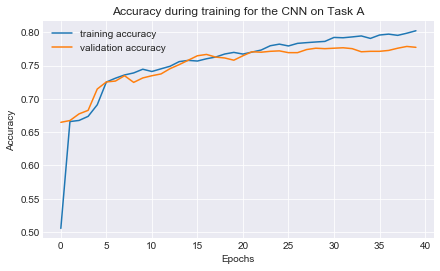

In [65]:
plt.figure(figsize=(7,4))
plt.plot([i for i in range(len(train_acc))], train_acc, label = 'training accuracy')
plt.plot([i for i in range(len(train_acc))], val_acc, label = 'validation accuracy')
plt.title('Accuracy during training for the CNN on Task A')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show();

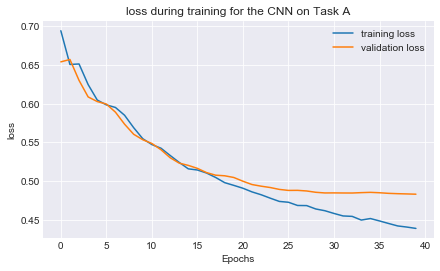

In [66]:
plt.figure(figsize=(7,4))
plt.plot([i for i in range(len(train_loss))], train_loss, label = 'training loss')
plt.plot([i for i in range(len(train_loss))], val_loss, label = 'validation loss')
plt.title('loss during training for the CNN on Task A')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show();

## Tests on official test set

In [48]:
predictions_off = model(test_sent_tensor_2).squeeze(1)
predictions_to_submit = torch.round(torch.sigmoid(predictions_off))

p = predictions_to_submit.detach().numpy()
p = ['OFF' if x == 1 else 'NOT' for x in p]

df_to_submit = pd.DataFrame(p)
df_to_submit.index = data_test.id
df_to_submit.to_csv('test_A.csv',sep=',', header = False)

df_to_submit.head(5)

,0
id,
15923,OFF
27014,NOT
30530,NOT
13876,NOT
60133,NOT


# Bayesian Optimization


In [39]:
def f(lr, wd, dp, epochs=28):
    epochs=epochs

    INPUT_DIM = len(word2idx)
    EMBEDDING_DIM = 100
    OUTPUT_DIM = 1

    #the hyperparamerts specific to CNN

    # we define the number of filters
    N_OUT_CHANNELS = 100
    # we define the window size
    WINDOW_SIZE = 1
    # we apply the dropout with the probability 0.5
    DROPOUT = dp

    model = CNN(INPUT_DIM, EMBEDDING_DIM, N_OUT_CHANNELS, WINDOW_SIZE, OUTPUT_DIM, DROPOUT)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.BCEWithLogitsLoss()

    feature_train = train_sent_tensor
    target_train = train_label_tensor

    feature_valid = valid_sent_tensor
    target_valid = valid_label_tensor


    for epoch in range(1, epochs+1):
   
        model.train()
  
        optimizer.zero_grad()
    
        predictions = model(feature_train).squeeze(1)
        loss = loss_fn(predictions, target_train)
        acc = accuracy(predictions, target_train)
        loss.backward()
        optimizer.step()
  
        epoch_loss = loss.item()
        epoch_acc = acc
      
        model.eval()
  
        with torch.no_grad():
 
            predictions_valid = model(feature_valid).squeeze(1)
            loss = loss_fn(predictions_valid, target_valid)
            acc = accuracy(predictions_valid, target_valid)
            valid_loss = loss.item()
            valid_acc = acc
            f1 = classification_report(target_valid, torch.round(torch.sigmoid(predictions_valid)), output_dict=True)['macro avg']['f1-score']
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.3f} | Train Acc: {epoch_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |Macro avg f1 {f1}% |')
        model.eval()
    
        feature = test_sent_tensor
        target = test_label_tensor

    with torch.no_grad():
 
        predictions = model(feature).squeeze(1)
        loss = loss_fn(predictions, target)
        acc = accuracy(predictions, target)
        print(f'| Test Loss: {loss:.3f} | Test Acc: {acc*100:.2f}%')
    return(valid_acc)

In [36]:
# Bounded region of parameter space
pbounds = {'lr': (0.00001, 0.05), 'wd': (0.000001, 0.01), 'dp': (0.05, 0.5)}

optimizer = BayesianOptimization(
    f=f,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(
    init_points=8,
    n_iter=8,
)

Initialization
-----------------------------------------------------------------
 Step |   Time |      Value |        dp |        lr |        wd | 
| Epoch: 01 | Train Loss: 0.685 | Train Acc: 56.88% | Val. Loss: 0.839 | Val. Acc: 66.87% |
| Epoch: 02 | Train Loss: 0.834 | Train Acc: 66.75% | Val. Loss: 0.650 | Val. Acc: 67.00% |
| Epoch: 03 | Train Loss: 0.644 | Train Acc: 67.07% | Val. Loss: 0.629 | Val. Acc: 69.87% |
| Epoch: 04 | Train Loss: 0.625 | Train Acc: 71.58% | Val. Loss: 0.653 | Val. Acc: 63.20% |
| Epoch: 05 | Train Loss: 0.650 | Train Acc: 64.18% | Val. Loss: 0.646 | Val. Acc: 65.47% |
| Epoch: 06 | Train Loss: 0.644 | Train Acc: 65.94% | Val. Loss: 0.624 | Val. Acc: 71.47% |
| Epoch: 07 | Train Loss: 0.621 | Train Acc: 71.97% | Val. Loss: 0.605 | Val. Acc: 73.93% |
| Epoch: 08 | Train Loss: 0.601 | Train Acc: 74.36% | Val. Loss: 0.594 | Val. Acc: 72.80% |
| Epoch: 09 | Train Loss: 0.589 | Train Acc: 72.87% | Val. Loss: 0.589 | Val. Acc: 71.40% |
| Epoch: 10 | Train Loss

| Epoch: 02 | Train Loss: 0.653 | Train Acc: 66.55% | Val. Loss: 0.673 | Val. Acc: 66.53% |
| Epoch: 03 | Train Loss: 0.667 | Train Acc: 66.76% | Val. Loss: 0.638 | Val. Acc: 67.00% |
| Epoch: 04 | Train Loss: 0.631 | Train Acc: 67.16% | Val. Loss: 0.609 | Val. Acc: 68.00% |
| Epoch: 05 | Train Loss: 0.601 | Train Acc: 68.65% | Val. Loss: 0.604 | Val. Acc: 71.33% |
| Epoch: 06 | Train Loss: 0.597 | Train Acc: 72.87% | Val. Loss: 0.604 | Val. Acc: 71.47% |
| Epoch: 07 | Train Loss: 0.599 | Train Acc: 72.60% | Val. Loss: 0.593 | Val. Acc: 72.00% |
| Epoch: 08 | Train Loss: 0.586 | Train Acc: 73.81% | Val. Loss: 0.574 | Val. Acc: 73.07% |
| Epoch: 09 | Train Loss: 0.565 | Train Acc: 74.56% | Val. Loss: 0.556 | Val. Acc: 73.87% |
| Epoch: 10 | Train Loss: 0.546 | Train Acc: 75.05% | Val. Loss: 0.546 | Val. Acc: 73.40% |
| Epoch: 11 | Train Loss: 0.538 | Train Acc: 74.89% | Val. Loss: 0.542 | Val. Acc: 73.60% |
| Epoch: 12 | Train Loss: 0.531 | Train Acc: 74.66% | Val. Loss: 0.536 | Val. Ac

| Epoch: 02 | Train Loss: 1.017 | Train Acc: 66.75% | Val. Loss: 0.644 | Val. Acc: 67.33% |
| Epoch: 03 | Train Loss: 0.638 | Train Acc: 67.27% | Val. Loss: 0.653 | Val. Acc: 64.33% |
| Epoch: 04 | Train Loss: 0.651 | Train Acc: 64.01% | Val. Loss: 0.681 | Val. Acc: 54.60% |
| Epoch: 05 | Train Loss: 0.680 | Train Acc: 55.88% | Val. Loss: 0.656 | Val. Acc: 64.80% |
| Epoch: 06 | Train Loss: 0.654 | Train Acc: 64.98% | Val. Loss: 0.631 | Val. Acc: 72.60% |
| Epoch: 07 | Train Loss: 0.627 | Train Acc: 73.20% | Val. Loss: 0.619 | Val. Acc: 73.07% |
| Epoch: 08 | Train Loss: 0.614 | Train Acc: 72.97% | Val. Loss: 0.615 | Val. Acc: 69.60% |
| Epoch: 09 | Train Loss: 0.610 | Train Acc: 69.16% | Val. Loss: 0.615 | Val. Acc: 67.47% |
| Epoch: 10 | Train Loss: 0.611 | Train Acc: 67.51% | Val. Loss: 0.612 | Val. Acc: 67.07% |
| Epoch: 11 | Train Loss: 0.610 | Train Acc: 67.35% | Val. Loss: 0.604 | Val. Acc: 67.93% |
| Epoch: 12 | Train Loss: 0.603 | Train Acc: 67.83% | Val. Loss: 0.595 | Val. Ac

In [40]:
f( 0.0093,  0.0003, 0.1910, epochs=50)

| Epoch: 01 | Train Loss: 0.681 | Train Acc: 58.86% | Val. Loss: 0.669 | Val. Acc: 66.87% |
| Epoch: 02 | Train Loss: 0.664 | Train Acc: 66.75% | Val. Loss: 0.646 | Val. Acc: 67.00% |
| Epoch: 03 | Train Loss: 0.639 | Train Acc: 67.18% | Val. Loss: 0.615 | Val. Acc: 68.80% |
| Epoch: 04 | Train Loss: 0.610 | Train Acc: 68.63% | Val. Loss: 0.605 | Val. Acc: 71.40% |
| Epoch: 05 | Train Loss: 0.599 | Train Acc: 72.34% | Val. Loss: 0.599 | Val. Acc: 72.73% |
| Epoch: 06 | Train Loss: 0.595 | Train Acc: 73.22% | Val. Loss: 0.584 | Val. Acc: 73.13% |
| Epoch: 07 | Train Loss: 0.579 | Train Acc: 73.93% | Val. Loss: 0.564 | Val. Acc: 73.27% |
| Epoch: 08 | Train Loss: 0.557 | Train Acc: 74.49% | Val. Loss: 0.550 | Val. Acc: 73.40% |
| Epoch: 09 | Train Loss: 0.542 | Train Acc: 74.52% | Val. Loss: 0.544 | Val. Acc: 73.93% |
| Epoch: 10 | Train Loss: 0.534 | Train Acc: 74.70% | Val. Loss: 0.534 | Val. Acc: 74.53% |
| Epoch: 11 | Train Loss: 0.524 | Train Acc: 75.34% | Val. Loss: 0.522 | Val. Ac

tensor(0.7833)